In [1]:
import os
import pandas as pd

path = '/home/srgrace/Downloads/IMS_PRO/Recommender_System/ml-latest-small'

In [2]:
ratings = pd.read_csv(os.path.join(path, 'ratings.csv'))
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
movies = pd.read_csv(os.path.join(path, 'movies.csv'))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
import numpy as np

g = ratings.groupby('userId')['rating'].count()
topUsers = g.sort_values(ascending=False)[:15]

g = ratings.groupby('movieId')['rating'].count()
topMovies = g.sort_values(ascending=False)[:15]

top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,1,50,110,260,296,318,356,480,527,589,593,1196,2571,2858,2959
userId,,,,,,,,,,,,,,,
68,2.5,3.0,2.5,5.0,2.0,3.0,3.5,3.5,4.0,3.5,3.5,5.0,4.5,5.0,2.5
182,4.0,4.5,3.5,3.5,5.0,4.5,5.0,3.5,4.0,2.0,4.5,3.0,5.0,5.0,5.0
249,4.0,4.0,5.0,5.0,4.0,4.5,4.5,4.0,4.5,4.0,4.0,5.0,5.0,4.5,5.0
274,4.0,4.0,4.5,3.0,5.0,4.5,4.5,3.5,4.0,4.5,4.0,4.5,4.0,5.0,5.0
288,4.5,NaN,5.0,5.0,5.0,5.0,5.0,2.0,5.0,4.0,5.0,4.5,3.0,NaN,3.5
307,4.0,4.5,3.5,3.5,4.5,4.5,4.0,3.5,4.5,2.5,4.5,3.0,3.5,4.0,4.0
380,5.0,4.0,4.0,5.0,5.0,3.0,5.0,5.0,NaN,5.0,5.0,5.0,4.5,NaN,4.0
387,NaN,4.5,3.5,4.5,5.0,3.5,4.0,3.0,NaN,3.5,4.0,4.5,4.0,4.5,4.5
414,4.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0


## Fastai collaborative filtering

In [6]:
from fastai.collab import CollabDataBunch, collab_learner


In [7]:
data = CollabDataBunch.from_df(ratings, valid_pct=0.1)
data.show_batch()

userId,movieId,target
294,1379,1.0
149,1375,2.0
232,30894,2.0
414,994,4.0
190,5816,5.0


## Neural collaborative filtering model

user: u -> (u1, u2, ....., un) <br>
movie: m -> (m1, m2, ...., mn) <br>
rating: r -> u.dot(m) -> u1*m1 + u2*m2 + .....+ un*mn <br>

In [15]:
learn = collab_learner(data, n_factors=40, y_range=[0,5.5], wd=.1)


The actual model created here contains 2 important enhancements on the simpler version described earlier:

First, apart from the vectors for users and movies, it also add bias terms to account for outliers, since some users tend to always rate movies very high or very low, and some movies tend to be universally acclaimed or disliked.


user: u -> (u1, u2, ....., un), ub <br>
movie: m -> (m1, m2, ...., mn), mb <br>
rating: r -> u.dot(m) -> u1*m1 + u2*m2 + .....+ un*mn + ub + mb <br>

Second, it applies the Sigmoid activation function to the above output, and scales it so that the result always lies in the given y_range, which is 0 to 5.5 in this case.


## Training the model
The learner uses the mean squared error loss function to evaluate the predictions of the model, and the Adam optimizer to adjust the parameters (vectors and biases) using gradient descent. Before we train the model, we use the learning rate finder to select a good learning for the optimizer.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


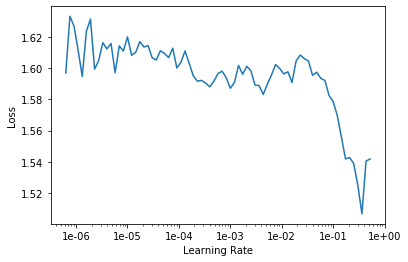

In [16]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

Upon inspection of the graph, we can see that the decrease in loss starts to decrease when the learning rate is around 1e-2. We can choose this as our learning rate, and train for 10 epochs, while annealing the learning rate using the 1-cycle policy, which leads to faster convergence.



In [21]:
learn.fit_one_cycle(2, 1e-2)


epoch,train_loss,valid_loss,time
0,0.520850,0.788877,00:12
1,0.399023,0.731534,00:12


## Looking at some predictions


In [22]:
(users, items), ratings = next(iter(data.valid_dl))
preds = learn.model(users, items)
print('Real\tPred\tDifference')
for p in list(zip(ratings, preds))[:16]:
    print('{}\t{:.1f}\t{:.1f}'.format(p[0],p[1],p[1]-p[0]))

Real	Pred	Difference
5.0	4.2	-0.8
5.0	3.5	-1.5
5.0	4.4	-0.6
2.0	2.5	0.5
0.5	3.1	2.6
4.0	4.4	0.4
4.0	4.2	0.2
2.5	3.2	0.7
2.5	2.9	0.4
4.0	4.0	-0.0
4.0	3.9	-0.1
3.0	2.8	-0.2
3.0	3.3	0.3
3.5	3.6	0.1
3.0	3.5	0.5
4.0	3.7	-0.3


## Deep Learning for Movie Recommendation

### MovieLens Data Processing

In [24]:
path1 = '/home/srgrace/Downloads/IMS_PRO/Recommender_System/ml-1m/'

# Define file directories
MOVIELENS_DIR = path1
USER_DATA_FILE = 'users.dat'
MOVIE_DATA_FILE = 'movies.dat'
RATING_DATA_FILE = 'ratings.dat'

# Specify User's Age and Occupation Column
AGES = { 1: "Under 18", 18: "18-24", 25: "25-34", 35: "35-44", 45: "45-49", 50: "50-55", 56: "56+" }
OCCUPATIONS = { 0: "other or not specified", 1: "academic/educator", 2: "artist", 3: "clerical/admin",
                4: "college/grad student", 5: "customer service", 6: "doctor/health care",
                7: "executive/managerial", 8: "farmer", 9: "homemaker", 10: "K-12 student", 11: "lawyer",
                12: "programmer", 13: "retired", 14: "sales/marketing", 15: "scientist", 16: "self-employed",
                17: "technician/engineer", 18: "tradesman/craftsman", 19: "unemployed", 20: "writer" }


# Define csv files to be saved into
USERS_CSV_FILE = 'users.csv'
MOVIES_CSV_FILE = 'movies.csv'
RATINGS_CSV_FILE = 'ratings.csv'


# Read the Ratings File
ratings = pd.read_csv(os.path.join(MOVIELENS_DIR, RATING_DATA_FILE), 
                    sep='::', 
                    engine='python', 
                    encoding='latin-1',
                    names=['user_id', 'movie_id', 'rating', 'timestamp'])

# Set max_userid to the maximum user_id in the ratings
max_userid = ratings['user_id'].drop_duplicates().max()
# Set max_movieid to the maximum movie_id in the ratings
max_movieid = ratings['movie_id'].drop_duplicates().max()

# Process ratings dataframe for Keras Deep Learning model
# Add user_emb_id column whose values == user_id - 1
ratings['user_emb_id'] = ratings['user_id'] - 1
# Add movie_emb_id column whose values == movie_id - 1
ratings['movie_emb_id'] = ratings['movie_id'] - 1


# Save into ratings.csv
ratings.to_csv(RATINGS_CSV_FILE, 
               sep='\t', 
               header=True, 
               encoding='latin-1', 
               columns=['user_id', 'movie_id', 'rating', 'timestamp', 'user_emb_id', 'movie_emb_id'])

# Read the Users File
users = pd.read_csv(os.path.join(MOVIELENS_DIR, USER_DATA_FILE), 
                    sep='::', 
                    engine='python', 
                    encoding='latin-1',
                    names=['user_id', 'gender', 'age', 'occupation', 'zipcode'])
users['age_desc'] = users['age'].apply(lambda x: AGES[x])
users['occ_desc'] = users['occupation'].apply(lambda x: OCCUPATIONS[x])

users.to_csv(USERS_CSV_FILE, 
             sep='\t', 
             header=True, 
             encoding='latin-1',
             columns=['user_id', 'gender', 'age', 'occupation', 'zipcode', 'age_desc', 'occ_desc'])

# Read the Movies File
movies = pd.read_csv(os.path.join(MOVIELENS_DIR, MOVIE_DATA_FILE), 
                    sep='::', 
                    engine='python', 
                    encoding='latin-1',
                    names=['movie_id', 'title', 'genres'])

# Save into movies.csv
movies.to_csv(MOVIES_CSV_FILE, 
              sep='\t', 
              header=True, 
              columns=['movie_id', 'title', 'genres'])

In [26]:

%matplotlib inline
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reading ratings file
ratings = pd.read_csv(os.path.join(path1, 'ratings.csv'), sep='\t', encoding='latin-1', 
                      usecols=['user_id', 'movie_id', 'user_emb_id', 'movie_emb_id', 'rating'])

max_userid = ratings['user_id'].drop_duplicates().max()
max_movieid = ratings['movie_id'].drop_duplicates().max()

# Reading ratings file
users = pd.read_csv(os.path.join(path1, 'users.csv'), sep='\t', encoding='latin-1', 
                    usecols=['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])

# Reading ratings file
movies = pd.read_csv(os.path.join(path1, 'movies.csv'), sep='\t', encoding='latin-1', 
                     usecols=['movie_id', 'title', 'genres'])

In [29]:

# Create training set
shuffled_ratings = ratings.sample(frac=1., random_state=42)

# Shuffling users
Users = shuffled_ratings['user_emb_id'].values
print('Users:', Users, ', shape =', Users.shape)

# Shuffling movies
Movies = shuffled_ratings['movie_emb_id'].values
print('Movies:', Movies, ', shape =', Movies.shape)

# Shuffling ratings
Ratings = shuffled_ratings['rating'].values
print('Ratings:', Ratings, ', shape =', Ratings.shape)


Users: [5411 5439  367  424 ... 2128  853 4032  785] , shape = (1000209,)
Movies: [2682  903 3716 1720 ... 2699 3101 3478 1390] , shape = (1000209,)
Ratings: [2 5 4 4 ... 5 3 5 4] , shape = (1000209,)


### Deep Learning Model
The idea of using deep learning is similar to that of Model-Based Matrix Factorization. In matrix factorizaion, we decompose our original sparse matrix into product of 2 low rank orthogonal matrices. For deep learning implementation, we don’t need them to be orthogonal, we want our model to learn the values of embedding matrix itself. The user latent features and movie latent features are looked up from the embedding matrices for specific movie-user combination. These are the input values for further linear and non-linear layers. We can pass this input to multiple relu, linear or sigmoid layers and learn the corresponding weights by any optimization algorithm (Adam, SGD, etc.).

### Build the Model

In [137]:
# A simple implementation of matrix factorization for collaborative filtering expressed as a Keras Sequential model


import numpy as np
from keras.layers import Embedding, Reshape, Dot
from keras.models import Sequential


class CFModel(Sequential):

    # The constructor for the class
    def __init__(self, n_users, m_items, k_factors, **kwargs):
        # P is the embedding layer that creates an User by latent factors matrix.
        # If the intput is a user_id, P returns the latent factor vector for that user.
        models = []
        P = Sequential()
        P.add(Embedding(n_users, k_factors, input_length=1))
        P.add(Reshape((k_factors,)))
        models.append(P)

        # Q is the embedding layer that creates a Movie by latent factors matrix.
        # If the input is a movie_id, Q returns the latent factor vector for that movie.
        Q = Sequential()
        Q.add(Embedding(m_items, k_factors, input_length=1))
        Q.add(Reshape((k_factors,)))
        models.append(Q)

        super(CFModel, self).__init__(**kwargs)
        
        # The Merge layer takes the dot product of user and movie latent factor vectors to return the 
        # corresponding rating.
        # self.add(Dot(axes=1)([P, Q]))
        
        self.add(Dot(axes=1)(models))

    # The rate function to predict user's rating of unrated items
    def rate(self, user_id, item_id):
        return self.predict([np.array([user_id]), np.array([item_id])])[0][0]

Here are the main components:

* A left embedding layer that creates a Users by Latent Factors matrix.
* A right embedding layer that creates a Movies by Latent Factors matrix.
* When the input to these layers are (i) a user id and (ii) a movie id, they'll return the latent factor vectors for the user and the movie, respectively.
* A merge layer that takes the dot product of these two latent vectors to return the predicted rating.

<img src="data/collaborative-filter.png">
<a href="http://www.fenris.org/2016/03/07/index-html">ref: fenris's blog</a>




In [138]:
# Import Keras libraries
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint


In [139]:
# Define constants
K_FACTORS = 100 # The number of dimensional embeddings for movies and users
TEST_USER = 2000 # A random test user (user_id = 2000)

In [140]:
# Define model
model = CFModel(max_userid, max_movieid, K_FACTORS)
# Compile the model using MSE as the loss function and the Adam learning algorithm
model.compile(loss='mse', optimizer='adam')

ValueError: Layer dot_14 was called with an input that isn't a symbolic tensor. Received type: <class 'keras.engine.sequential.Sequential'>. Full input: [<keras.engine.sequential.Sequential object at 0x7f3166f98910>, <keras.engine.sequential.Sequential object at 0x7f3166daf210>]. All inputs to the layer should be tensors.

### Train the Model

In [ ]:
# Callbacks monitor the validation loss
# Save the model weights each time the validation loss has improved
callbacks = [EarlyStopping('val_loss', patience=2), 
             ModelCheckpoint('weights.h5', save_best_only=True)]

# Use 30 epochs, 90% training data, 10% validation data 
history = model.fit([Users, Movies], Ratings, nb_epoch=30, validation_split=.1, verbose=2, callbacks=callbacks)

### Root Mean Square Error
During the training process above, I saved the model weights each time the validation loss has improved. Thus, I can use that value to calculate the best validation Root Mean Square Error.

In [ ]:
# Show the best validation RMSE
min_val_loss, idx = min((val, idx) for (idx, val) in enumerate(history.history['val_loss']))
print('Minimum RMSE at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(math.sqrt(min_val_loss)))

Minimum RMSE at epoch 17 = 0.8616 <br>


The best validation loss is 0.7424 at epoch 17. Taking the square root of that number, I got the RMSE value of 0.8616, which is better than the RMSE from the SVD Model (0.8736).

In [ ]:

# Use the pre-trained model
trained_model = CFModel(max_userid, max_movieid, K_FACTORS)
# Load weights
trained_model.load_weights('weights.h5')

In [ ]:
# Function to predict the ratings given User ID and Movie ID
def predict_rating(user_id, movie_id):
    return trained_model.rate(user_id - 1, movie_id - 1)

In [ ]:
user_ratings = ratings[ratings['user_id'] == TEST_USER][['user_id', 'movie_id', 'rating']]
user_ratings['prediction'] = user_ratings.apply(lambda x: predict_rating(TEST_USER, x['movie_id']), axis=1)
user_ratings.sort_values(by='rating', 
                         ascending=False).merge(movies, 
                                                on='movie_id', 
                                                how='inner', 
                                                suffixes=['_u', '_m']).head(10)

### Recommend Movies

In [ ]:
recommendations = ratings[ratings['movie_id'].isin(user_ratings['movie_id']) == False][['movie_id']].drop_duplicates()
recommendations['prediction'] = recommendations.apply(lambda x: predict_rating(TEST_USER, x['movie_id']), axis=1)
recommendations.sort_values(by='prediction',
                          ascending=False).merge(movies,
                                                 on='movie_id',
                                                 how='inner',
                                                 suffixes=['_u', '_m']).head(10)